In [4]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [38]:
from spire.utils import *
from spire.operators.image import *
from spire.tomography.tomography import AstraToolbox
from time import time

In [7]:
ph = np.load("data/Brain512.npz")["data"]
tomo = AstraToolbox(ph.shape[1], 40)
tomo2 = AstraToolbox(ph.shape[1], 40, cudafbp=True)
tomo2.set_filter("hamming")
tomo2b = AstraToolbox(ph.shape[1]//2, 40, cudafbp=True)
tomo2b.set_filter("hamming")

In [9]:
si = tomo.proj(ph)
si_n = si + np.random.randn(*si.shape)*si.max()*1./100
P = lambda x : tomo.proj(x)
PT = lambda x : tomo.backproj(x)
P2 = lambda x : tomo2.proj(x)/tomo2.n_a*pi/2
P2T = lambda x : tomo2.fbp(x)
P2b = lambda x : tomo2b.proj(x)/tomo2b.n_a*pi/2
P2bT = lambda x : tomo2b.fbp(x)


In [8]:
# Binning along x axis (sinogram domain)
bin12 = lambda x : x.reshape(x.shape[0], x.shape[1]//2, 2).mean(axis=-1)
# Zooming (image domain)
zoom2 = lambda img : np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(img)), (img.shape[0]*2, img.shape[1]*2)))*4.

In [39]:
from spire.algorithms.chambollepock import chambolle_pock_tv_wavelets
from pypwt import Wavelets
W = Wavelets(ph*0, "haar", 99)
Wb = Wavelets(np.zeros((256, 256)), "haar", 99)

# Regular TV-Wavelets reconstruction

In [40]:
n_it0 = 451
t0 = time()
rw = chambolle_pock_tv_wavelets(si_n/tomo2.n_a*pi/2, P2, P2T, W, 0.9, 0.5, n_it=n_it0, return_all=False)
el = (time()-t0)*1.0
print("Ellapsed time for standard reconstruction: %.2f s" % el)

Warn: chambolle_pock(): Lipschitz constant not provided, computing it with 20 iterations
L = 3.448233e+00
Ellapsed time for standard reconstruction: 6.65 s


# Downsampled reconstruction, as an initial solution

In [65]:
n_it_subs = 551
t0 = time()
rwb = chambolle_pock_tv_wavelets(bin12(si_n)/tomo2b.n_a*pi/2, P2b, P2bT, Wb, 0.6, 0.1, n_it=n_it_subs, return_all=False)
elb = (time()-t0)*1.0
print("Ellapsed time for binned reconstruction: %.2f s" % elb)

Warn: chambolle_pock(): Lipschitz constant not provided, computing it with 20 iterations
L = 3.420811e+00
Ellapsed time for binned reconstruction: 3.44 s


In [72]:
n_it2 = 201
t0 = time()
rw2 = chambolle_pock_tv_wavelets(si_n/tomo2.n_a*pi/2, P2, P2T, W, 0.9, 0.1, n_it=n_it2, x0=zoom2(rwb/2.), return_all=False)
el2 = (time()-t0)*1.0
print("Ellapsed time for reconstruction after binned : %.2f s" % el2)

Warn: chambolle_pock(): Lipschitz constant not provided, computing it with 20 iterations
L = 3.448233e+00
Ellapsed time for reconstruction after binned : 3.49 s


<IPython.core.display.Javascript object>


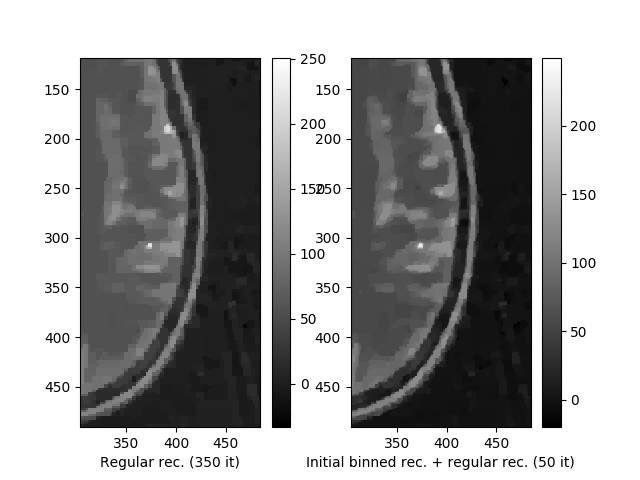

In [73]:
ims([rw, rw2], cmap="gray", legend=["Regular rec. (350 it)", "Initial binned rec. + regular rec. (50 it)"])

In [74]:
mse1 = norm2sq(rw - ph)/ph.size
mse2 = norm2sq(rw2 - ph)/ph.size
print("MSE \t regular = %e \t binned+reg = %e" % (mse1, mse2))

MSE 	 regular = 1.659100e+02 	 binned+reg = 1.227461e+02


In [31]:
sqrt(norm2sq(rw2 - ph))

6420.079438760863

# Standard reconstruction with "only" TV

In [45]:
from spire.algorithms.chambollepock import chambolle_pock_tv

In [69]:
n_it_tv = 1501
t0 = time()
rtv = chambolle_pock_tv(si_n/tomo2.n_a*pi/2, P2, P2T, 0.9, n_it=n_it_tv, return_all=False)
el_tv = (time()-t0)*1.0
print("Ellapsed time for standard reconstruction: %.2f s" % el_tv)

Warn: chambolle_pock(): Lipschitz constant not provided, computing it with 20 iterations
L = 3.448233e+00
Ellapsed time for standard reconstruction: 25.84 s


<IPython.core.display.Javascript object>


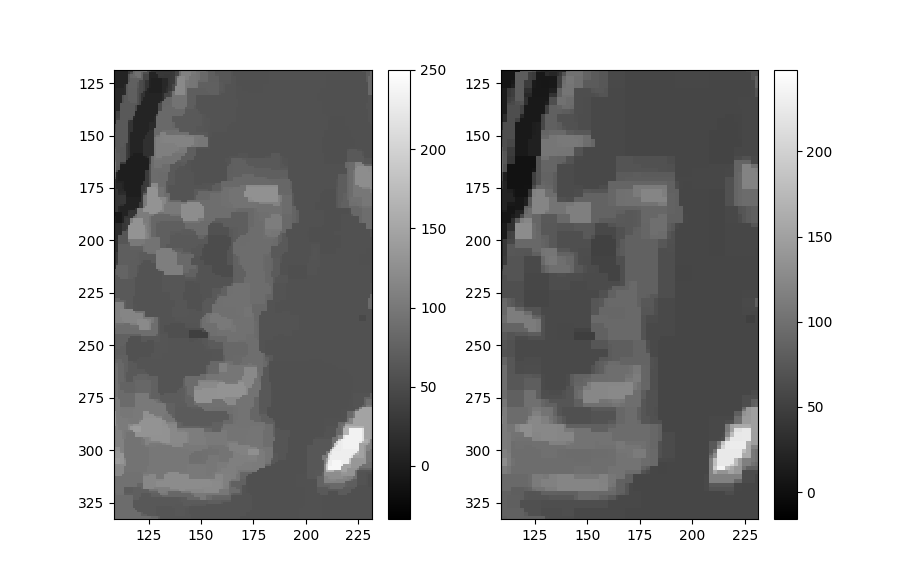

In [70]:
ims([rtv, rw2], cmap="gray")

In [71]:
mse3 = norm2sq(ph - rtv)/ph.size
print("MSE \t regular TV = %e \t binned+reg = %e" % (mse3, mse2))

MSE 	 regular TV = 1.227174e+02 	 binned+reg = 1.447719e+02


TODO: automate reconstructions to build a table:
        
Method                    n_iter    time (s)    MSE    Comments
TV
TV+Wavelets
TV (rebin)
TV+Wavelets (rebin)        
        
what is interesting is to make n_iter vary, to see which is the quickest to reach a given quality      

For n_it_subs = 551  and n_it2 = 201, I have
  time_binned = 3.44s  ; time_rec = 3.90s ;  MSE = 1.447e+02
On the other hand, with TV-Wavelets regular, n_it = 1501 : time = 20.71s, MSE = 1.470e+02
  

In [75]:
chambolle_pock_tv_wavelets?